<center>
    <h1> INF477 - Redes Neuronales Artificiales  </h1>
    <h2> Tarea #2 - Parte III: Redes Convolucionales en Google Street View </h2> 
</center>

Tarea realizada por:
* Alvaro Salinas - `alvaro.salinase@gmail.com` - **rol:** 201073001-8
* Martín Villanueva - `martin.villanueva@alumnos.usm.cl` - **rol:** 201104012-0

_DI UTFSM. Septiembre 2016._

## Tabla de Contenidos
* [Redes Convolucionales en Google Street View](#conv)
    * [Parte (a)](#a)
    * [Parte (b)](#b)
    * [Parte (c)](#c)
    * [Parte (d)](#d)
    * [Parte (e)](#e)
    * [Parte (f)](#f)
    * [Parte (g)](#g)
    * [Parte (h)](#h)
    * [Parte (i)](#i)
    * [Parte (j)](#j)
    * [Bonus](#bonus)

<div id='conv'/>
## Redes Convolucionales en Google Street View


In [147]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.io as sio
import numpy as np
import random

In [119]:
from keras.utils import np_utils
from keras.models import Sequential, model_from_json
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D, AveragePooling2D
from keras.optimizers import SGD, Adadelta, Adagrad
from keras import backend as K

In [2]:
def load_file(name):
    a = open('results-part3/'+name+'.txt')
    t = int(a.readline().strip())
    loss = map(float,a.readline().strip().split(','))
    acc = map(float,a.readline().strip().split(','))
    a.close()
    return t,loss,acc

In [148]:
def plot(loss):
    ne = len(loss.values()[0])
    ep = range(1,ne+1)
    plt.figure(figsize=(15,5))
    for i in loss:
        plt.plot(ep,loss[i],'o-',label=i)
    plt.title('Loss vs Epoch')
    plt.xlabel('Numero Epoch')
    plt.ylabel('Loss')
    plt.xlim(1,ne)
    plt.grid()
    plt.legend(bbox_to_anchor=(1, 1))
    plt.show()
    plt.close()

In [98]:
def load_keras_model(model_name):
    model_name = model_name.split('.')[0]
    # load json and create model
    json_file = open('{0}.json'.format(model_name), 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights('{0}.h5'.format(model_name))
    return loaded_model

<div id='a'/>
### Parte (a)

In [89]:
train_data = sio.loadmat('train_32x32.mat')
test_data = sio.loadmat('test_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_test = test_data['X'].T
y_test = test_data['y'] - 1
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
n_classes = len(np.unique(y_train))

In [91]:
print "Tamano de las imagenes:", X_train.shape[2],'x',X_train.shape[3]
print "Numero de clases:", n_classes
print "Numero de ejemplos por categoria:"
print "|{0:^15}|".format("Categoria", 'centered'),
for i in np.unique(y_train):
    print "{0:^6}|".format(str(i), 'centered'),
print "{0:^8}|".format("Total", 'centered')
print "|{0:^15}|".format("Entrenamiento", 'centered'),
for i in np.unique(y_train):
    print "{0:^6}|".format(str(np.where(y_train==i)[0].shape[0]), 'centered'),
print "{0:^8}|".format(str(y_train.shape[0]), 'centered')
print "|{0:^15}|".format("Prueba", 'centered'),
for i in np.unique(y_train):
    print "{0:^6}|".format(str(np.where(y_test==i)[0].shape[0]), 'centered'),
print "{0:^8}|".format(str(y_test.shape[0]), 'centered')

Tamano de las imagenes: 32 x 32
Numero de clases: 10
Numero de ejemplos por categoria:
|   Categoria   |   0   |   1   |   2   |   3   |   4   |   5   |   6   |   7   |   8   |   9   |  Total  |
| Entrenamiento | 13861 | 10585 |  8497 |  7458 |  6882 |  5727 |  5595 |  5045 |  4659 |  4948 |  73257  |
|    Prueba     |  5099 |  4149 |  2882 |  2523 |  2384 |  1977 |  2019 |  1660 |  1595 |  1744 |  26032  |


In [92]:
def resize_img(im):
    a = np.zeros((32,32,3))
    for rgb in range(len(im)):
        for i in range(len(im[rgb])):
            for j in range(len(im[rgb][i])):
                a[j][i][rgb] = im[rgb][i][j]
    return a

Visualizacion de imagenes aleatorias:


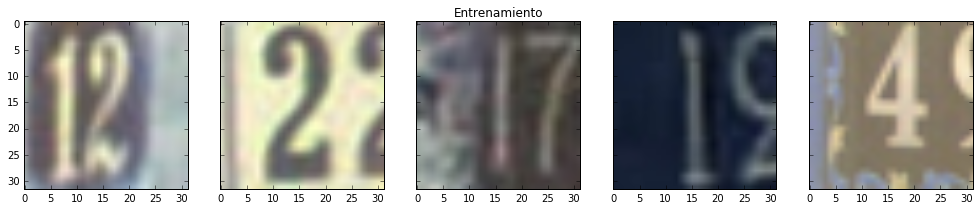

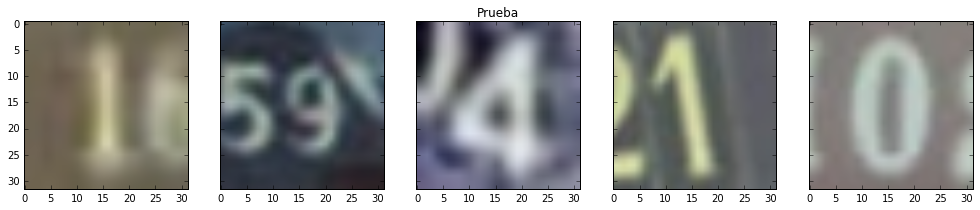

In [93]:
print "Visualizacion de imagenes aleatorias:"
f, ax = plt.subplots(1, 5, sharey=True, figsize=(17,3))
ax[2].set_title("Entrenamiento")
for i in range(5):
    ax[i].imshow(resize_img(random.choice(X_train)))
f, ax = plt.subplots(1, 5, sharey=True, figsize=(17,3))
ax[2].set_title("Prueba")
for i in range(5):
    ax[i].imshow(resize_img(random.choice(X_test)))

Como comentario, podemos decir que las imágenes vienen en un formato no adecuado para su visualización, por lo que fue necesario crear la funcion resize_img() para darles las dimensiones correctas. Por otro lado, se ve que las imágenes son bastante "borrosas", incluso no puediendo el ojo humano decifrar el número que aparece en algunas de ellas, por lo que es bastante interesante y motivador el hecho de descubrir lo que una red neuronal puede lograr respecto a este problema de clasificación.

<div id='b'/>
### Parte (b)

In [94]:
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)
Y_test = np_utils.to_categorical(y_test, n_classes)

<div id='c'/>
### Parte (c)

In [96]:
n_channels = X_train.shape[1]
n_rows = X_train.shape[2]
n_cols = X_train.shape[3]
model = Sequential()
model.add(Convolution2D(16, 5, 5, border_mode='same', activation='relu',input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, 7, 7, border_mode='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_3 (Convolution2D)  (None, 16, 32L, 32L)  1216        convolution2d_input_2[0][0]      
____________________________________________________________________________________________________
maxpooling2d_3 (MaxPooling2D)    (None, 16, 16L, 16L)  0           convolution2d_3[0][0]            
____________________________________________________________________________________________________
convolution2d_4 (Convolution2D)  (None, 512, 16L, 16L) 401920      maxpooling2d_3[0][0]             
____________________________________________________________________________________________________
maxpooling2d_4 (MaxPooling2D)    (None, 512, 8L, 8L)   0           convolution2d_4[0][0]            
___________________________________________________________________________________________

<div id='d'/>
### Parte (d)

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1280, nb_epoch=12, verbose=0, validation_data=(X_test, Y_test))

In [149]:
ns = [20,50,100,200]
names = ['d20','d50','d100','d200']
accs = []
times = []
dloss = {}
for n in names:
    t,loss,acc = load_file(n)
    accs.append(round(acc[-1],3))
    times.append(t)
    dloss[n] = loss

In [150]:
print "|{0:^10}|".format("Neuronas", 'centered'),
for j in ns:
    print "{0:^8}|".format(str(j), 'centered'),
print "\n|{0:^10}|".format("Accuracy", 'centered'),
for i in accs:
    print "{0:^8}|".format(str(i), 'centered'),
print "\n|{0:^10}|".format("Tiempo", 'centered'),
for i in times:
    print "{0:^8}|".format(str(i), 'centered'),

| Neuronas |    20   |    50   |   100   |   200   | 
| Accuracy |  0.838  |  0.838  |  0.967  |  0.838  | 
|  Tiempo  |   1098  |   1104  |   1114  |   1129  |


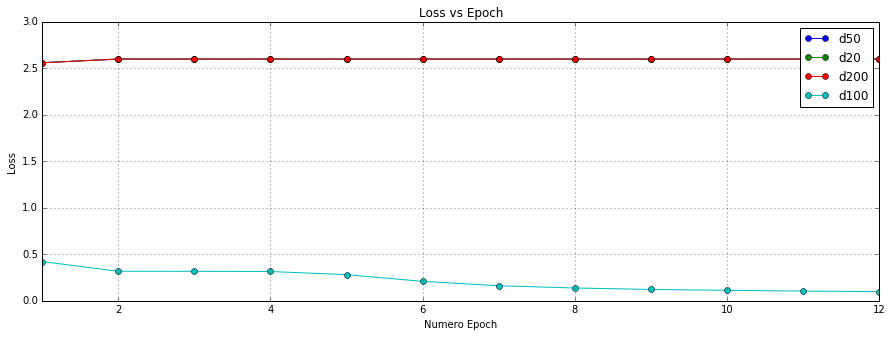

In [151]:
plot(dloss)

<div id='e'/>
### Parte (e)

In [ ]:
accs = []
cf_list = [3,5,7,9]
cp_list = [2,4]
for cf_size in cf_list:
    for cp_size in cp_list:
        model = Sequential()
        model.add(Convolution2D(16,cf_size,cf_size, border_mode='same',activation='relu',input_shape=(n_channels, n_rows, n_cols)))
        model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
        model.add(Convolution2D(512,cf_size,cf_size, border_mode='same',activation='relu'))
        model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
        model.add(Flatten())
        model.add(Dense(20, activation='relu'))
        model.add(Dense(n_classes, activation='softmax'))
        model.compile(loss='binary_crossentropy', optimizer='adagrada, metrics=['accuracy'])
        model.fit(X_train, Y_train, batch_size=1280, nb_epoch=10, verbose=0, validation_data=(X_test, Y_test))
        scores = model.evaluate(X_test,Y_test,verbose=0)
        accs.append(scores[1]*100)

In [152]:
cf_list = [3,5,7,9]
cp_list = [2,4]
names = ['3-2','3-4','5-2','5-4','7-2','7-4','9-2','9-4']
accs = []
times = []
dloss = {}
for n in names:
    t,loss,acc = load_file(n)
    accs.append(round(acc[-1],3))
    times.append(t)
    dloss[n] = loss

In [153]:
print "|{0:^10}|".format("Filtro", 'centered'),
for i in cf_list:
    print "{0:^18}|".format(str(i)+'x'+str(i), 'centered'),
print "\n|{0:^10}|".format("Pooling", 'centered'),
for j in cf_list:
    for i in cp_list:
        print "{0:^8}|".format(str(i)+'x'+str(i), 'centered'),
print "\n|{0:^10}|".format("Accuracy", 'centered'),
for i in accs:
    print "{0:^8}|".format(str(i), 'centered'),
print "\n|{0:^10}|".format("Tiempo", 'centered'),
for i in times:
    print "{0:^8}|".format(str(i), 'centered'),

|  Filtro  |        3x3        |        5x5        |        7x7        |        9x9        | 
| Pooling  |   2x2   |   4x4   |   2x2   |   4x4   |   2x2   |   4x4   |   2x2   |   4x4   | 
| Accuracy |   0.97  |  0.921  |  0.974  |  0.947  |  0.959  |  0.952  |  0.838  |  0.941  | 
|  Tiempo  |   577   |   514   |   828   |   549   |   1136  |   720   |   1424  |   940   |


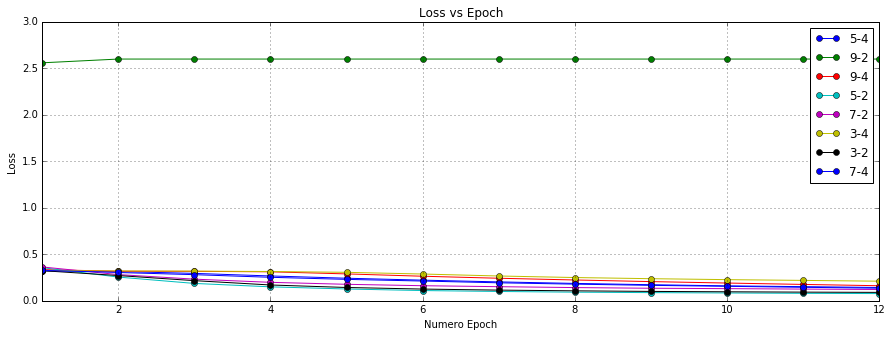

In [154]:
plot(dloss)

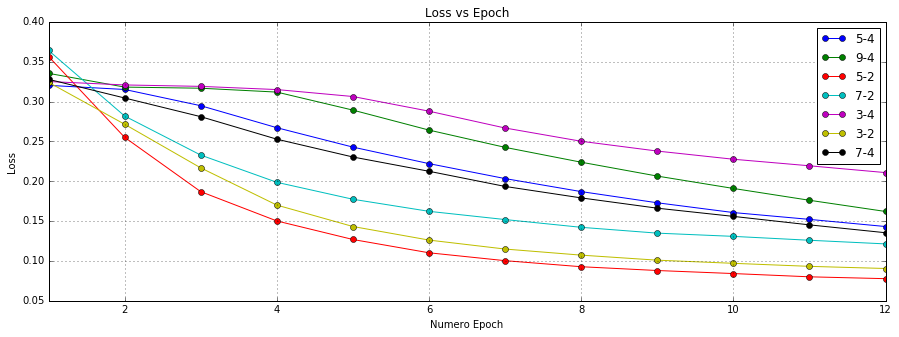

In [155]:
del dloss['9-2']
plot(dloss)

<div id='f'/>
### Parte (f)

In [33]:
n_filters_l1 = 32
n_filters_l2 = 64
model = Sequential()
model.add(Convolution2D(n_filters_l1,cf_size,cf_size,border_mode='same',activation='relu',input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
model.add(Convolution2D(n_filters_l2,cf_size,cf_size,border_mode='same',activation='relu'))
model.add(MaxPooling2D(pool_size=(cp_size,cp_size)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_7 (Convolution2D)  (None, 32, 32L, 32L)  896         convolution2d_input_4[0][0]      
____________________________________________________________________________________________________
maxpooling2d_7 (MaxPooling2D)    (None, 32, 16L, 16L)  0           convolution2d_7[0][0]            
____________________________________________________________________________________________________
convolution2d_8 (Convolution2D)  (None, 64, 16L, 16L)  18496       maxpooling2d_7[0][0]             
____________________________________________________________________________________________________
maxpooling2d_8 (MaxPooling2D)    (None, 64, 8L, 8L)    0           convolution2d_8[0][0]            
___________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1280, nb_epoch=12, verbose=0, validation_data=(X_test, Y_test))

In [156]:
f_list = [16,32,64]
names = ['16-3-2','32-3-2','64-3-2']
accs = []
times = []
dloss = {}
for n in names:
    t,loss,acc = load_file(n)
    accs.append(round(acc[-1],3))
    times.append(t)
    dloss[n] = loss

In [157]:
print "|{0:^10}|".format("Filtros", 'centered'),
for j in f_list:
    print "{0:^8}|".format(str(j), 'centered'),
print "\n|{0:^10}|".format("Accuracy", 'centered'),
for i in accs:
    print "{0:^8}|".format(str(i), 'centered'),
print "\n|{0:^10}|".format("Tiempo", 'centered'),
for i in times:
    print "{0:^8}|".format(str(i), 'centered'),

| Filtros  |    16   |    32   |    64   | 
| Accuracy |  0.958  |  0.965  |  0.959  | 
|  Tiempo  |   327   |   373   |   495   |


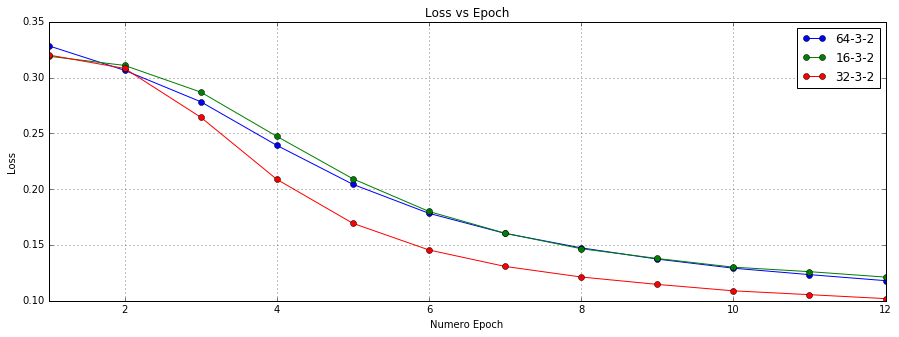

In [158]:
plot(dloss)

<div id='g'/>
### Parte (g)

In [34]:
model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',activation='relu',input_shape=(3,32,32)))
model.add(Convolution2D(32, 3, 3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_9 (Convolution2D)  (None, 32, 32, 32)    896         convolution2d_input_5[0][0]      
____________________________________________________________________________________________________
convolution2d_10 (Convolution2D) (None, 32, 30, 30)    9248        convolution2d_9[0][0]            
____________________________________________________________________________________________________
maxpooling2d_9 (MaxPooling2D)    (None, 32, 15, 15)    0           convolution2d_10[0][0]           
____________________________________________________________________________________________________
convolution2d_11 (Convolution2D) (None, 256, 15, 15)   73984       maxpooling2d_9[0][0]             
___________________________________________________________________________________________

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1280, nb_epoch=12, verbose=0, validation_data=(X_test, Y_test))

Tiempo de entrenamiento: 1618
Accuracy: 0.958137789321


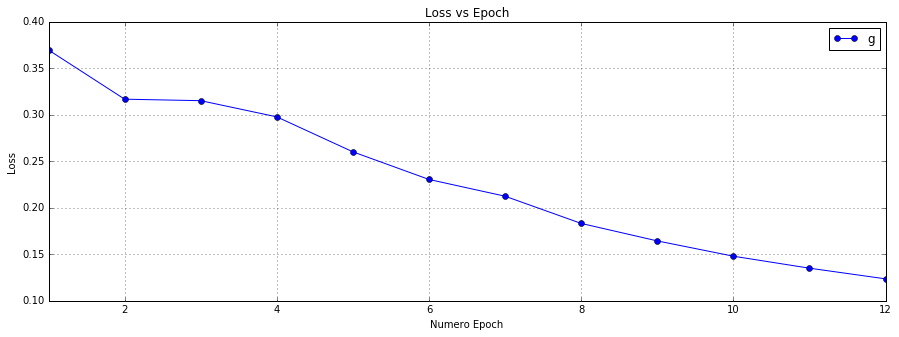

In [159]:
t,loss,acc = load_file('g')
loss = {'g':loss}
print 'Tiempo de entrenamiento:', t
print 'Accuracy:', acc[-1]
plot(loss)

<div id='h'/>
### Parte (h)

Se usara la red con mayor accuracy hasta el momento, es decir, aquella con filtros de tamaño $5 \times 5$ en las capas convolucionales y de $2 \times 2$ en las de pooling de la <b>Parte (e)</b>.

In [99]:
model = load_keras_model('results-part3/5-2')
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])

In [104]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 16, 32, 32)    1216        convolution2d_input_3[0][0]      
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 16, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 512, 16, 16)   205312      maxpooling2d_1[0][0]             
____________________________________________________________________________________________________
maxpooling2d_2 (MaxPooling2D)    (None, 512, 8, 8)     0           convolution2d_2[0][0]            
___________________________________________________________________________________________

In [110]:
w = model.layers[0].get_weights()
print 'Pesos:', w[0].shape
print 'Bias:', w[1].shape
print w[0]
print w[1]

Pesos: (16L, 3L, 5L, 5L)
Bias: (16L,)
[[[[  1.11815911e-02   9.96115878e-02  -1.14616930e-01   5.88919856e-02
     -6.63641691e-02]
   [ -6.18725782e-03   6.83434010e-02  -5.95973618e-02  -2.08800174e-02
      2.23180670e-02]
   [ -6.75230175e-02   1.58016328e-02   1.82039309e-02  -7.94304982e-02
     -6.98031038e-02]
   [ -6.27263710e-02   1.34671628e-02   3.34695391e-02  -9.26973596e-02
     -3.42703573e-02]
   [ -9.16248262e-02   9.10838917e-02  -1.68119799e-02  -5.91323562e-02
      4.83180583e-02]]

  [[  1.53936177e-01  -7.84487501e-02  -7.23161921e-02  -3.17803062e-02
     -9.96790975e-02]
   [ -7.68068731e-02  -1.10738978e-01  -1.10119075e-01  -6.17316589e-02
      2.37352848e-02]
   [ -6.94016367e-02   2.24032961e-02  -6.56995028e-02  -1.14087030e-01
      3.65099162e-02]
   [ -8.42060596e-02   8.17674100e-02  -1.34354318e-02   2.59090923e-02
     -3.68800648e-02]
   [  5.18396683e-02  -7.25876465e-02  -9.68086198e-02   2.60992423e-02
      4.10167724e-02]]

  [[  1.76322591e-

Imagen a visualizar:


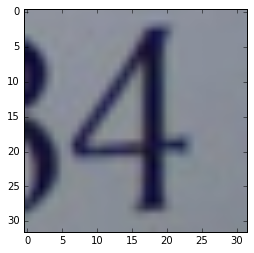

In [141]:
img = random.choice(X_test)
print 'Imagen a visualizar:'
plt.figure()
plt.imshow(resize_img(img))
plt.show()
plt.close()

In [142]:
get_1st_layer_output = K.function([model.layers[0].input],[model.layers[0].output])
layer_output = get_1st_layer_output([np.array([img])])[0]

Filtros:


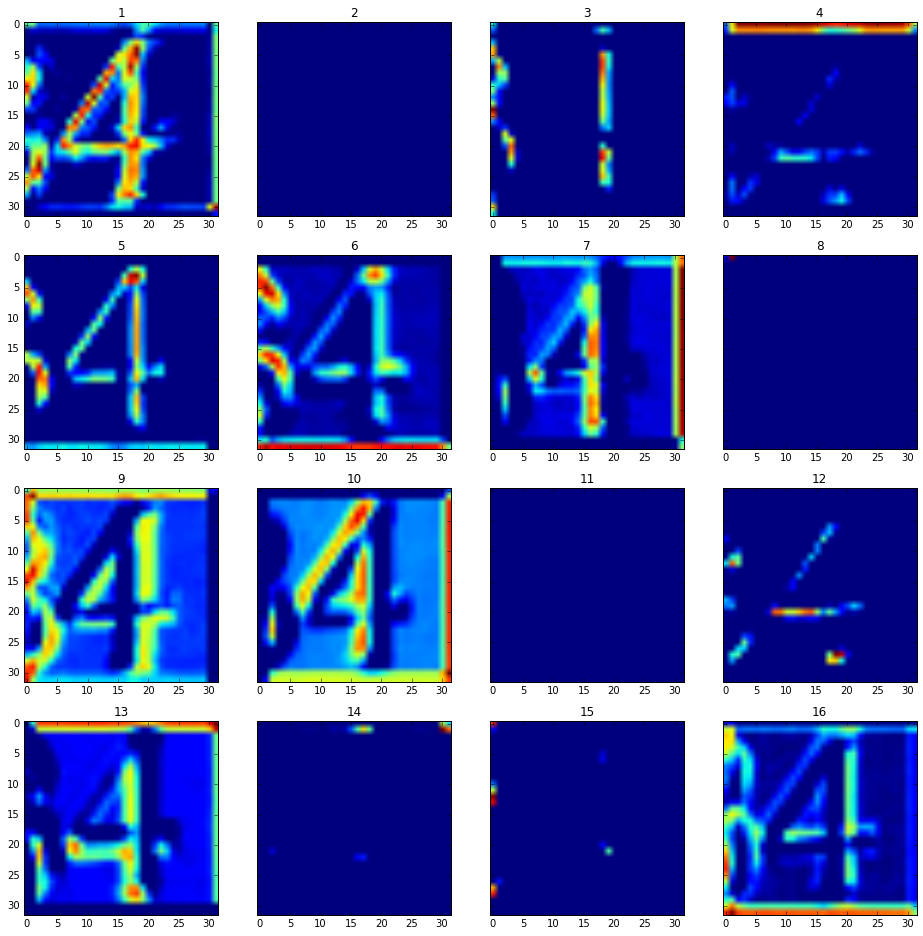

In [146]:
filters = layer_output[0]
print "Filtros:"
f, ax = plt.subplots(4, 4, sharey=True, figsize=(16,16))
for i in range(4):
    for j in range(4):
        nf = 4*(i) + j + 1
        ax[i][j].set_title(nf)
        ax[i][j].imshow(np.transpose(filters[nf-1]))

<div id='i'/>
### Parte (i)

In [35]:
model = Sequential()
model.add(Convolution2D(32, 3, 3,border_mode='same',activation='relu',input_shape=(3,32,32)))
model.add(Convolution2D(32, 3, 3,activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
model.add(Convolution2D(256, 3, 3, activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_13 (Convolution2D) (None, 32, 32, 32)    896         convolution2d_input_6[0][0]      
____________________________________________________________________________________________________
convolution2d_14 (Convolution2D) (None, 32, 30, 30)    9248        convolution2d_13[0][0]           
____________________________________________________________________________________________________
maxpooling2d_11 (MaxPooling2D)   (None, 32, 15, 15)    0           convolution2d_14[0][0]           
____________________________________________________________________________________________________
convolution2d_15 (Convolution2D) (None, 256, 15, 15)   73984       maxpooling2d_11[0][0]            
___________________________________________________________________________________________

In [ ]:
sgd = SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer=sgd, metrics=['accuracy'])
batch_size = 1280
n_epoch = 20
model.fit(X_train, Y_train, batch_size=batch_size, nb_epoch=n_epoch, verbose=1,validation_data=(X_test, Y_test))

Tiempo de entrenamiento: 2770
Accuracy: 0.986900914382


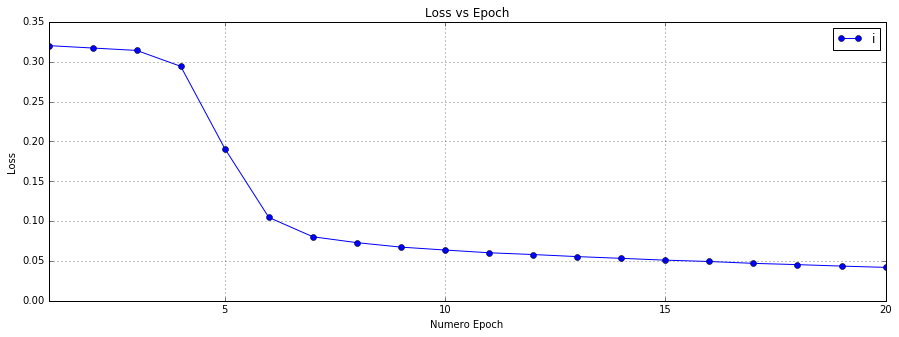

In [160]:
t,loss,acc = load_file('i')
loss = {'i':loss}
print 'Tiempo de entrenamiento:', t
print 'Accuracy:', acc[-1]
plot(loss)

<div id='j'/>
### Parte (j)

In [ ]:
train_data = sio.loadmat('extra_32x32.mat')
X_train = train_data['X'].T
y_train = train_data['y'] - 1
X_train = X_train.astype('float32')

In [ ]:
X_train /= 255
Y_train = np_utils.to_categorical(y_train, n_classes)

In [ ]:
model = Sequential()
model.add(Convolution2D(16, 5, 5, border_mode='valid', activation='relu',input_shape=(n_channels, n_rows, n_cols)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(512, 7, 7, border_mode='valid', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(20, activation='relu'))
model.add(Dense(n_classes, activation='softmax'))
model.summary()

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='adagrad', metrics=['accuracy'])
model.fit(X_train, Y_train, batch_size=1280, nb_epoch=12, verbose=0, validation_data=(X_test, Y_test))

In [161]:
t,loss,acc = load_file('extra')
dloss = {'extra':loss}
print 'Tiempo de entrenamiento:', t
print 'Accuracy:', acc[-1]

Tiempo de entrenamiento: 7274
Accuracy: 0.991708639105


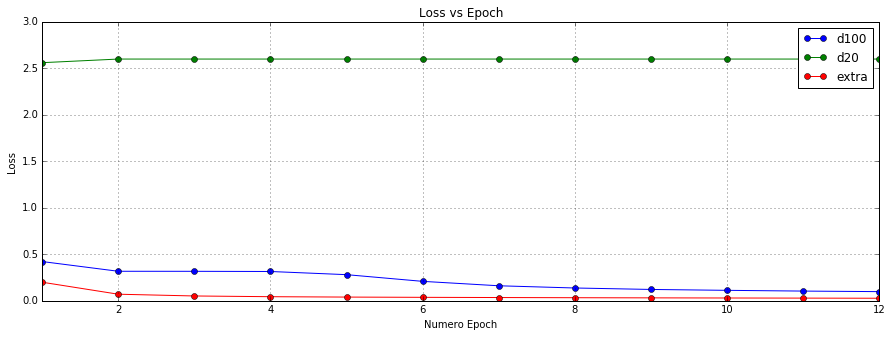

In [162]:
names = ['d20','d100']
for n in names:
    t,loss,acc = load_file(n)
    dloss[n] = loss
plot(dloss)

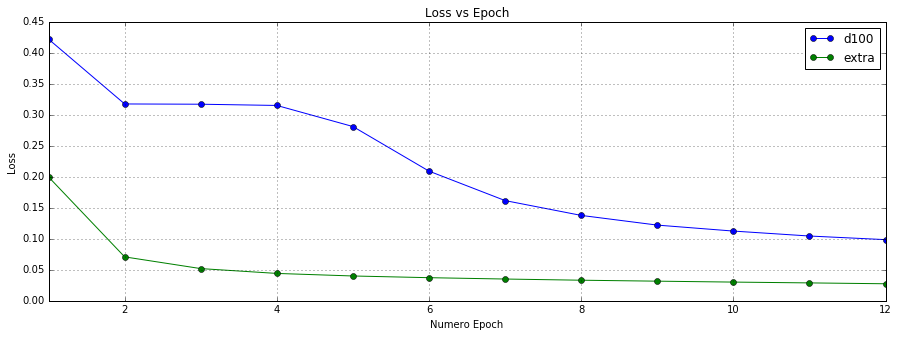

In [163]:
del dloss['d20']
plot(dloss)

<div id='bonus'/>
### Bonus

In [164]:
f_list = ['1 (8x8)','2 (4x4)','3 (2x2)']
names = ['k1x8','k2x4','k3x2']
accs = []
times = []
dloss = {}
for n in names:
    t,loss,acc = load_file(n)
    accs.append(round(acc[-1],3))
    times.append(t)
    dloss[n] = loss

In [165]:
print "|{0:^10}|".format("Filtros", 'centered'),
for j in f_list:
    print "{0:^8}|".format(str(j), 'centered'),
print "\n|{0:^10}|".format("Accuracy", 'centered'),
for i in accs:
    print "{0:^8}|".format(str(i), 'centered'),
print "\n|{0:^10}|".format("Tiempo", 'centered'),
for i in times:
    print "{0:^8}|".format(str(i), 'centered'),

| Filtros  | 1 (8x8) | 2 (4x4) | 3 (2x2) | 
| Accuracy |  0.829  |  0.962  |  0.969  | 
|  Tiempo  |   1344  |   1933  |   1700  |


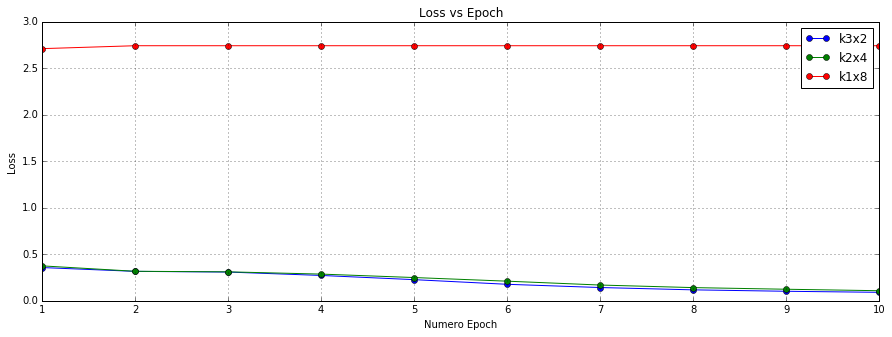

In [166]:
plot(dloss)